## Gpu

In [11]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Libraries

In [12]:
import torch
import torchvision # vision operations
import torch.optim as optim # optimizer
import torch.nn.functional as F # functions
import numpy as np # linear algebra
import torch.nn as nn # Convolutionals layers and other operations 
from torchvision import transforms # transform image
from  torchvision.datasets import MNIST # dataset
import matplotlib.pyplot as plt # vizualization
import os 
from torchvision.utils import save_image # save image from  output
from warnings import filterwarnings 
filterwarnings("ignore")

## Constants

In [13]:
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
NOISE_FACTOR = 0.5

## Get data

In [14]:
train_loader = torch.utils.data.DataLoader(
    MNIST(root = "./dataset", train=True, download = True, 
    transform  = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
    ),batch_size = BATCH_SIZE, shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    MNIST(root = "./dataset", train=False, download = True, 
    transform  = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
    ),batch_size = BATCH_SIZE, shuffle = True
)

torch.Size([16, 1, 28, 28])
tensor(1.)
tensor(-1.)


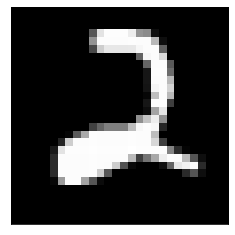

In [15]:
for data  in train_loader:
    images, _ = data
    print(images.shape)
    print(images[0,:,:,:].max())
    print(images[0,:,:,:].min())
    plt.imshow(images[0,0,:,:],cmap = plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    break
plt.show()

In [16]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device
# create folder
def make_dir():
    image_dir = 'Saved_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
# save output and input images
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

## Autoencoder Model

In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(1, 512, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(256, 56, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(56, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 56, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(56, 256, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(256, 512, kernel_size=2, stride=2)
        self.out = nn.Conv2d(512, 1, kernel_size=3, padding=1)
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.leaky_relu(self.dec1(x))
        x = F.leaky_relu(self.dec2(x))
        x = F.leaky_relu(self.dec3(x))
        x = F.leaky_relu(self.dec4(x))
        x = F.sigmoid(self.out(x))
        return x
net = Autoencoder()
print(net)


Autoencoder(
  (enc1): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(256, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(56, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 56, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(56, 256, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [18]:
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(net.parameters(), LEARNING_RATE)

## Train

In [19]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data 
            # we do not need the image labels
            # add noise to the image data
            img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
            # clip to make the values fall between 0 and 1
            img_noisy = np.clip(img_noisy, 0., 1.)
            img_noisy = img_noisy.to(device)
            optimizer.zero_grad()
            outputs = net(img_noisy)
            loss = criterion(outputs, img_noisy)
            # backpropagation
            loss.backward()
            # update the parameters
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))

        save_decoded_image(img_noisy.cpu().data, name='./Saved_Images/noisy{}.png'.format(epoch))
        save_decoded_image(outputs.cpu().data, name='./Saved_Images/denoised{}.png'.format(epoch))

    return train_loss

Epoch 1 of 10, Train Loss: 0.045
Epoch 2 of 10, Train Loss: 0.040
Epoch 3 of 10, Train Loss: 0.039
Epoch 4 of 10, Train Loss: 0.038
Epoch 5 of 10, Train Loss: 0.038
Epoch 6 of 10, Train Loss: 0.038
Epoch 7 of 10, Train Loss: 0.037
Epoch 8 of 10, Train Loss: 0.037
Epoch 9 of 10, Train Loss: 0.037
Epoch 10 of 10, Train Loss: 0.037


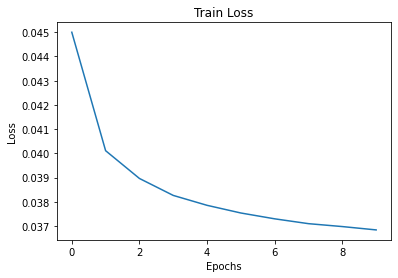

In [20]:
device = get_device()
net.to(device)
make_dir()
train_loss = train(net, train_loader, 10)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('./Saved_Images/loss.png')

## Test

In [21]:
def test(net, testloader):
     for batch in testloader:
        img, _ = batch
        img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
        img_noisy = np.clip(img_noisy, 0., 1.)
        img_noisy = img_noisy.to(device)
        outputs = net(img_noisy)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(img_noisy, 'noisy_test_input.png')
        save_image(outputs, 'denoised_test.png')
        break

In [22]:
test(net, test_loader)